# Expected Performance Tests

In this notebook, I will be focusing on grasping the basics of using a ResNet, as well improve my understanding of its underlying principles.

In order to ascertain the expected performance of the (later developed) CNN, I will be using the aforementioned ResNet for classification on the raw dataset. This will allow for a fair comparison/tradeoff between understanding if my developed model is under/over performing.

In other words, the transfer learning results will be used as a performance reference.

## Why ResNet?

### Concept

The concept of a Residual Network was conceived when dealing with the vanishing gradient problem related to Deep Neural Networks, an issue that led to inneficient/irrelevant weight updates, significantly increasing training time and simmultaneous performance degradation.

ResNets represent a type of architecture capable of learning **Residual Functions** instead of attempting to perfect full transformations, which allows for implementation of deeper networks while potentially avoiding exploding/vanishing gradients. 

### Learning
 
Instead of attempting to learn the function that transforms the inputs into outputs, a ResNet learns the residual, which represents the difference between te input and output. Essentially, it identifies small transformations for the input, which is usually much easier to learn, as a residual represents an approximation of the actual function.

Choosing the simplest, most shallow version of ResNet allows for a good starting point of expectd performance, as it will attempt to learn approximations of transformations for the DICOM data in the numpy arrays.

### Architecture


<div style="width: 70%; margin: 0 auto; text-align: center;">
    <img src="../z_imgs/ResNet-18-Architecture.png" alt="Hounsfield Units">
</div>


### Implementation

I will start by importing all necessary libraries, as well as the model itself:

In [1]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from scipy.ndimage import gaussian_filter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import albumentations as A
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import random
import os


# -----------  ResNet -----------

# Core library
import torch

# Essentials for development
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights

# Data resize (ResNet uses (224,224) inputs)
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

# Allows for paralell batch processing
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import decode_image

c:\Users\hasht\anaconda3\envs\fibrosis\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Loads the model
resnet18_example = models.resnet18(weights=ResNet18_Weights.DEFAULT)

The original ResNet18 was designed for ImageNet, which has 1000 possible classes. Since our problem consists of binary classification, the last layer needs the following modification:

In [3]:
num_ftrs = resnet18_example.fc.in_features
resnet18_example.fc = nn.Linear(num_ftrs, 2)  

In [4]:
# Resizing numpy arrays
transform = transforms.Resize((224, 224))

In order to obtain valid results, the train test split must be done following the recommended data division. Every slice ID starting with "SerieCT" is to be used as a test/validation split.

In [5]:
# Loads the dataframe
df_fibrosis = pd.read_pickle(r'..\..\\fibrosis_data.pkl')

In [6]:
df_fibrosis.head()

,SliceID,SliceData,Class
0,101__CT-0002-0001,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
1,101__CT-0002-0002,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
2,101__CT-0002-0003,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
3,101__CT-0002-0004,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
4,101__CT-0002-0005,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0


## From Dataframe to Dataset

Torch expects a Dataset instead of a Dataframe. In order to avoid complex transformations, I will be creating a `Dataset` class based on the previously defined df_fibrosis Dataframe, capable of reading the .np arrays as content.

In this case, we will have a `csv` file containing every ID and respective label (**annotations_file**) as well as a directory containing data pertaining to the DICOM slice images (**img_dir**). 

In [7]:
df_annotations = df_fibrosis.drop(columns="SliceData")
df_annotations["SliceID"] = df_annotations["SliceID"].astype(str) + ".npy" # better for data loader
df_annotations.head()

,SliceID,Class
0,101__CT-0002-0001.npy,0
1,101__CT-0002-0002.npy,0
2,101__CT-0002-0003.npy,0
3,101__CT-0002-0004.npy,0
4,101__CT-0002-0005.npy,0


Since ResNet has been trained to use only RGB images and DICOM images are in grayscale, I have chosen to [implement this approach](https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images):

"There is an easy way, though, which you can make your model work with grayscale images. You just need to make the image to appear to be RGB. The easiest way to do so is to repeat the image array 3 times on a new dimension. Because you will have the same image over all 3 channels, the performance of the model should be the same as it was on RGB images.

In numpy this can be easily done like this:"

```py
print(grayscale_batch.shape)  # (64, 224, 224)
rgb_batch = np.repeat(grayscale_batch[..., np.newaxis], 3, -1)
print(rgb_batch.shape)  # (64, 224, 224, 3)
```

In PyTorch, this can be done like so:

```python
transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
```

 - **Input shape**: The input `x` is a single-channel (grayscale) image of shape `(1, H, W)` (where `H` is the height and `W` is the width of the image).
 - **`x.repeat(3, 1, 1)`**: This repeats the grayscale image along the first axis (the channel axis) three times. The resulting shape is `(3, H, W)`, which means that the image now appears to have three channels, one for each of Red, Green, and Blue. **Each of these channels contains the same pixel values as the original grayscale image.**

### Data Integrity
This approach does not alter the original pixel values in the image. It simply duplicates the grayscale image across all three channels. The integrity of the data is preserved because no new information is added to the image—each of the three channels contains the same grayscale values.

In [8]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # idx represents index
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])

        # Load the .npy file
        image = np.load(img_path)
        
        #image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        # Adds random set of augmentations
        if self.albumentations:
            augmented = self.albumentations(image=image)
            image = augmented['image']

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
            # Gaussian Blur
            gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
            # Random choice
            image = random.choice((gauss_noise,gauss_blur))

        # Guarantee compatibility
        if self.gauss or self.albumentations: image = image.astype(np.float32)

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

All of the train-test-validation splits were previously doccumented and performed in `2 - testSplit`:

In [9]:
# Paths
img_dir = r"..\..\np_ROI_data"
annotations_file_train = r"trainTestHRCT\train_hrct.csv"
annotations_file_test = r"trainTestHRCT\test_hrct.csv"
annotations_file_val = r"trainTestHRCT\val_hrct.csv"


# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

Let's check if the contents changed to tensor and represent an image of size ((224,224)) with 1 grayscale dimension (adapted to 3 RGB):

In [10]:
def checkShape(train_dataset, dataset_size=len(train_dataset)):

    # Random choice of Slice
    idx = random.choice(range(dataset_size))

    # Identifies name of file corresponding to the first line of the train dataset
    slice_id = train_dataset.img_labels.iloc[idx, 0]  
    print(f"SliceID at index {idx}: {slice_id}")

    # Pulls first index of value of pandas series element with corresponding id -> 
    # -> gets np array and displays original shape
    print("\nOriginal np.array shape:")
    print((df_fibrosis["SliceData"][df_fibrosis["SliceID"] == slice_id[:-4]]).values[0].shape)

    print("----------------------")

    # Pulls "image" value from the (image, label) pair in the train dataset -> 
    # -> gets torch tensor and displays new shape
    print("\nTransformed tensor shape:")
    print(train_dataset[idx][0].shape)

In [11]:
checkShape(train_dataset)

SliceID at index 882: 172__CT.1.3.12.2.1107.5.1.4.58006.30000007020507000578100001066.npy

Original np.array shape:
(512, 512)
----------------------

Transformed tensor shape:
torch.Size([3, 224, 224])


In [12]:
def tensorVSnp(dataset, rgb=True):

    # Random choice of Slice
    idx = random.choice(range(len(dataset)))

    # Identifies name of file corresponding to random line of the train dataset
    slice_id = dataset.img_labels.iloc[idx, 0]  
    print(f"SliceID at index {idx}: {slice_id}")

    # Pulls first index of value of pandas series element with corresponding id -> 
    # -> gets np array 
    np_array = (df_fibrosis["SliceData"][df_fibrosis["SliceID"] == slice_id[:-4]]).values[0]

    # Pulls "image" value from the (image, label) pair in the train dataset -> 
    # -> gets torch tensor 
    tensor_rgb = (dataset[idx][0])

    # Normalize tensor (needed for plotting)
    full_tensor_rgb = (tensor_rgb - tensor_rgb.min()) / (tensor_rgb.max() - tensor_rgb.min())

    # Convert PyTorch tensor to NumPy (swaps dimension orders for compatibility with plot)
    full_tensor_rgb_np = full_tensor_rgb.permute(1, 2, 0).cpu().numpy()
    tensor_rgb_np = tensor_rgb.permute(1, 2, 0).cpu().numpy()

    print(tensor_rgb_np.shape)

    # Plot images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Numpy Image
    axes[0].imshow(np_array, cmap='gray')  
    axes[0].set_title("Original np.array")

    # Tensor Image (full RGB)
    axes[1].imshow(full_tensor_rgb_np)  
    axes[1].set_title("Transformed Tensor")

    # ----------- RGB

    if rgb:

        # Separate plot for RGB channels 
        fig2, axes2 = plt.subplots(1, 3, figsize=(15, 5))

        # Display the Red channel
        axes2[0].imshow(tensor_rgb_np[:, :, 0], cmap="gray")  # R channel
        axes2[0].set_title("Red Channel")

        # Display the Green channel
        axes2[1].imshow(tensor_rgb_np[:, :, 1], cmap="gray")  # G channel
        axes2[1].set_title("Green Channel")

        # Display the Blue channel
        axes2[2].imshow(tensor_rgb_np[:, :, 2], cmap="gray")  # B channel
        axes2[2].set_title("Blue Channel")

    plt.show()

SliceID at index 360: 128__CT-0007-0010.npy
(224, 224, 3)


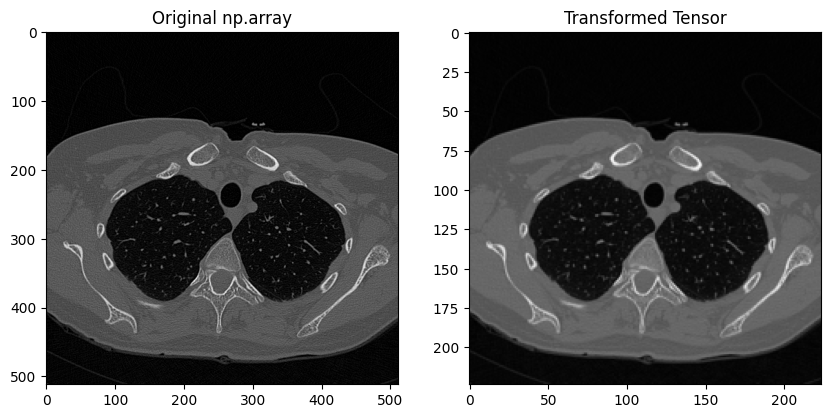

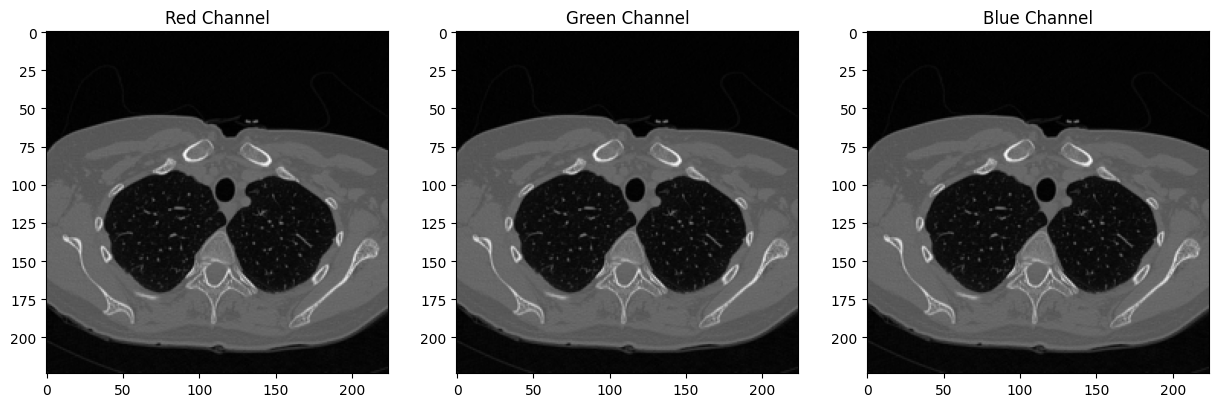

In [13]:
tensorVSnp(train_dataset)

As we can see, the transformation was successful and maintains relative data integrity, but some details were lost. This is due to the resize of (224,224) for ResNet compatibility.

Copying data to create the illusion of RGB for the ResNet input data is not destructive, as the nature of the transformation should not cause any blurriness. It does not apply any smoothing or averaging; it only replicates the grayscale data across the RGB channels. Since the pixel values remain the same across all channels, the image quality is not affected, and the image is not blurred. This is demonstrated in the separate plot of each color channel above.

Therefore, the logical conclusion is that the blurring found in the plot simply portrays the result of normalizing and resizing data, and does not represent data corruption.

## ResNet Training

Important consideration: "0" classification does not mean the lung is healthy. Because ILD manifests itsef in various forms, it is likely that the model could have issues identifying common patterns between:

 - a healthy lung
 - emphysema
 - ground_glass
 - micronodules
 - consolidation
 - bronchial_wall_thickening
 - reticulation
 - macronodules
 - cysts
 - peripheral_micronodules
 - bronchiectasis
 - air_trapping
 - early_fibrosis
 - increased_attenuation
 - tuberculosis
 - pcp

, as they were all paired into "0" classification.

The large variety of possible lung patterns may cause the ResNet to focus on learning residual functions for the presence of unusual structures, **rather than the absence of structures**. 

Additionally, the fact that there were very few slices with fibrosis may help the ResNet specify patterns, especially if their representation was strong and quite different from most of the manifestations represented above.

In [ ]:
def trainResNet(train_dataset, val_dataset, num_epochs=55, batch_size=32, lr=5e-7, patience=5, improve_min=0.001):
    # New ResNet instance
    resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

    # Use only 2 output neurons
    num_ftrs = resnet18.fc.in_features
    resnet18.fc = nn.Linear(num_ftrs, 2)  

    # If graphics card is available, uses it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet18.to(device)

    print("*"+("-"*29)+"*")
    print("|{:^29}|".format(f"Using {device}"))
    print("*"+("-"*29)+"*")

    # Generate data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Loss function 
    criterion = nn.CrossEntropyLoss()  
    # ADAM
    optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)

    # add learning_rate_scheduler e step learning rate

    # Initializing early stop counter (based on validation loss)
    best_loss = 99999999
    early_stop_ctr = 0

    loss_array = []
    val_loss_array = []


    for epoch in range(num_epochs):
        resnet18.train()
        running_loss = 0.0
        running_val_loss = 0.0


        # --------------- Weight updates ---------------
        
        # Iterates over each image in dataset, updates weights
        for images, labels in tqdm((train_loader), desc = "Training..."):
            images, labels = images.to(device), labels.to(device)
            
            # Applies ADAM 
            optimizer.zero_grad()

            # Generates output
            outputs = resnet18(images)

            # Computes loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Computes average training loss
        avg_loss_train = running_loss/len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {avg_loss_train:.6f}")
        loss_array.append(avg_loss_train)


        # ---------------- Validation Loss -----------------

        # Iterates over each image in dataset, computes validation loss
        for images, labels in (val_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Applies ADAM 
            optimizer.zero_grad()

            # Generates output
            outputs = resnet18(images)

            # Computes loss
            val_loss = criterion(outputs, labels)
            
            running_val_loss += val_loss.item()

        # Computes average validation loss
        avg_loss_val = running_val_loss/len(val_loader)
        print(f"Validation loss: {avg_loss_val:.6f}")
        val_loss_array.append(avg_loss_val)
        
        
        # ---------------- Early Stopping -----------------

        # Only after a high number of epochs (around 45)
        if epoch > 45:
            # Check for improvement (1% standard)
            if abs(best_loss - avg_loss_val) > (best_loss * improve_min):
                best_loss = avg_loss_val
                early_stop_ctr = 0
            else: early_stop_ctr += 1

            # Checks early stopping condition
            if early_stop_ctr >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs!!!")
                break
    
    return resnet18, loss_array, val_loss_array

In [15]:
models_path = "..\\..\\trainedResNets\\"

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    resnet_hrct, hrct_loss, hrct_val_loss = trainResNet(train_dataset,val_dataset)

    with open(r'pickleJar\hrct_loss.pkl', 'wb') as f:
        pickle.dump(hrct_loss, f)

    with open(r'pickleJar\hrct_val_loss.pkl', 'wb') as f:
        pickle.dump(hrct_val_loss, f)

elif ans == "read": 
    resnet_hrct = torch.load((f"{models_path}"+"resnet_hrct.pkl"))

    with open(r'pickleJar\hrct_loss.pkl', 'rb') as f:
        hrct_loss = pickle.load(f)

    with open(r'pickleJar\hrct_val_loss.pkl', 'rb') as f:
        hrct_val_loss = pickle.load(f)
    

else: print("Invalid answer, try again.")

C:\Users\hasht\AppData\Local\Temp\ipykernel_4888\267352167.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_hrct = torch.load((f"{models_path}"+"resnet_hrct.pkl")

In [16]:
ans = str(input("Do you wish to save?"))

if ans == "yes": torch.save(resnet_hrct, (f"{models_path}"+"resnet_hrct.pkl"))
else: print("DID NOT SAVE")

DID NOT SAVE


### Generate ROC and Best Threshold

In [17]:
def getROC(model, val_dataset): 

    all_labels, all_scores = [], []
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            # Translate logits to Class 1 probabilities using softmax
            # (pulls column 1 values and assigns probabilities)
            probs = F.softmax(outputs, dim=1)[:, 1]  

            all_scores.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    
    # Compute distance to (0,1) for each point on the ROC curve
    distances = np.sqrt((fpr)**2 + (1 - tpr)**2)

    # Gets closest point to the perfect discriminator (0,1)
    best_idx = np.argmin(distances)
    best_threshold = thresholds[best_idx]

    # ---------- Display and Results ---------- 

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold = {best_threshold:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    print("Area Under Curve:", roc_auc)
    print("Best Threshold (closest to (0,1)):", best_threshold)

    return best_threshold, roc_auc


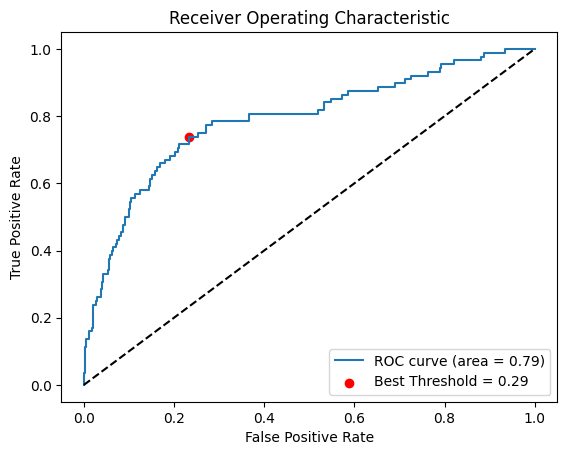

Area Under Curve: 0.788676588897828
Best Threshold (closest to (0,1)): 0.2915108


In [18]:
threshold_hrct, auc_hrct = getROC(resnet_hrct, val_dataset)

### Loss Evolution

In [19]:
def plotLoss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

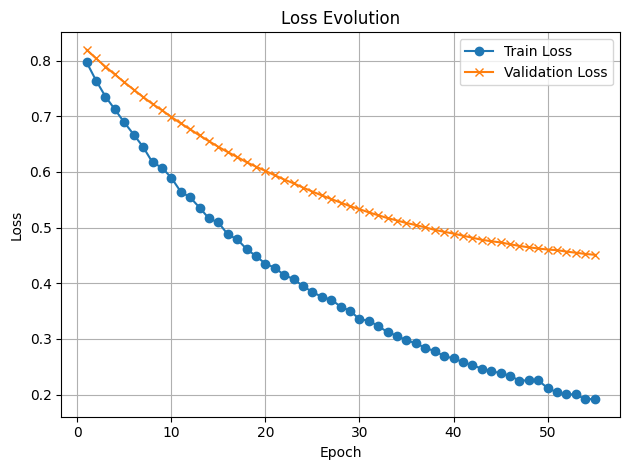

In [20]:
plotLoss(hrct_loss, hrct_val_loss)

In [21]:
def evalResNet(resnet18, test_dataset, threshold, auc):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Counters for each class
    correct, total = 0, 0
    correct_class_0, total_class_0 = 0, 0
    correct_class_1, total_class_1 = 0, 0

    # Needed for F1 score and confusion matrix
    y_true = []
    y_pred = []


    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Transform outputs to probabilities
            outputs = resnet18(images)

            # Translate logits to Class 1 probabilities using softmax
            probs = F.softmax(outputs, dim=1)[:, 1] 

            # Translate prob vs threshold to predictions
            # True if prob >= threshold else False
            # .long() transforms True/False to 1/0
            predicted = (probs >= threshold).long()
            
            # Update total and correct for general accuracy
            total += labels.size(0)

            correct += (predicted == labels).sum().item()

            # Class-specific accuracy
            for label, pred in zip(labels, predicted):
                if label == 0:
                    total_class_0 += 1
                    if pred == label:
                        correct_class_0 += 1
                elif label == 1:
                    total_class_1 += 1
                    if pred == label:
                        correct_class_1 += 1

            # Add data to lists
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(predicted.cpu().tolist())



    # Weights == inverse proportions
    weight_0, weight_1 = 0.133, 0.867

    print("Total examples:", total)

    # -------------------------------     Perfomance Metrics     -------------------------------

    # Accuracy
    accuracy_class_0 = 100 * (correct_class_0 / total_class_0) if total_class_0 > 0 else 0
    accuracy_class_1 = 100 * (correct_class_1 / total_class_1) if total_class_1 > 0 else 0
    accuracy = 100 * (correct / total)
    accuracy2 = 100 * ((correct_class_0 + correct_class_1) / total)
    weighted_accuracy = ((accuracy_class_0*weight_0) + (accuracy_class_1*weight_1))

    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro') # Assigns same importance to each class
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_class_0 = f1_score(y_true, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_true, y_pred, pos_label=1)

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred)


    # -------------------------------     Print Results     -------------------------------

    # Accuracy
    print("\n --------------------- \n")
    print(f"Accuracy for Class 0: {accuracy_class_0:.2f}%  ({correct_class_0} in {total_class_0})")
    print(f"Accuracy for Class 1: {accuracy_class_1:.2f}%  ({correct_class_1} in {total_class_1})")
    print(f"Test Accuracy: {accuracy:.2f}%")
    if f"{accuracy:.2f}" != f"{accuracy2:.2f}": print("ERROR CALCULATING ACCURACIES")
    print(f"Weighted Accuracy: {weighted_accuracy:.2f}%")

    # AUC
    print("\n --------------------- \n")
    print("Area Under Curve:", auc)

    # F1 scores
    print("\n --------------------- \n")
    print(f"F1 Score (Macro): {f1_macro:.3f}")
    print(f"F1 Score (Weighted): {f1_weighted:.3f}")
    print(f"F1 Score Class 0: {f1_class_0:.3f}")
    print(f"F1 Score Class 1: {f1_class_1:.3f}")

    # Confusion matrix
    print("\n --------------------- \n")
    print("\nConfusion Matrix: \n", conf_mat)

In [22]:
evalResNet(resnet_hrct, test_dataset,threshold_hrct,auc_hrct)

Total examples: 301

 --------------------- 

Accuracy for Class 0: 80.61%  (237 in 294)
Accuracy for Class 1: 57.14%  (4 in 7)
Test Accuracy: 80.07%
Weighted Accuracy: 60.26%

 --------------------- 

Area Under Curve: 0.788676588897828

 --------------------- 

F1 Score (Macro): 0.503
F1 Score (Weighted): 0.870
F1 Score Class 0: 0.888
F1 Score Class 1: 0.118

 --------------------- 


Confusion Matrix: 
 [[237  57]
 [  3   4]]


## Conclusions (HRCT_Pilot)

The drastic and different imbalances present in both the training and testing datasets strongly affected the model's ability to learn and identify meaningful patterns in the data. This is clearly portrayed through the difference in accuracy performance when comparing 0-Class and 1-Class. 

## Custom Test Split

The next expected performance analysis will be done on a custom test split, created by the script in `2 - testSplit`. 

In [23]:
# Defining paths
train_df = r"trainTestCustom\train.csv"
test_df = r"trainTestCustom\test.csv"
val_df = r"trainTestCustom\val.csv"

In [24]:
# Paths
img_dir = r'..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = train_df
annotations_file_test = test_df
annotations_file_val = val_df


# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

In [25]:
print(torch.cuda.is_available())          
print(torch.cuda.get_device_name(0))     

for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

True
NVIDIA GeForce RTX 3070
Device 0: NVIDIA GeForce RTX 3070


In [26]:
models_path = "..\\..\\trainedResNets\\"

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    resnet_custom, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset,num_epochs=40)

    with open(r'pickleJar\custom_loss.pkl', 'wb') as f:
        pickle.dump(custom_loss, f)

    with open(r'pickleJar\custom_val_loss.pkl', 'wb') as f:
        pickle.dump(custom_val_loss, f)

elif ans == "read": 
    resnet_custom = torch.load((f"{models_path}"+"resnet_custom.pkl"))

    with open(r'pickleJar\custom_loss.pkl', 'rb') as f:
        custom_loss = pickle.load(f)

    with open(r'pickleJar\custom_val_loss.pkl', 'rb') as f:
        custom_val_loss = pickle.load(f)
    

else: print("Invalid answer, try again.")

C:\Users\hasht\AppData\Local\Temp\ipykernel_4888\3669536769.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_custom = torch.load((f"{models_path}"+"resnet_custom.

In [156]:
ans = str(input("Do you wish to save?"))

if ans == "yes": torch.save(resnet_custom, (f"{models_path}"+"resnet_custom.pkl"))
else: print("DID NOT SAVE")

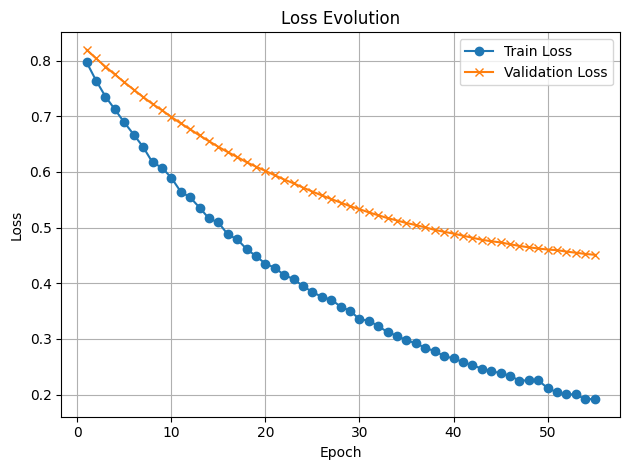

In [27]:
plotLoss(hrct_loss, hrct_val_loss)

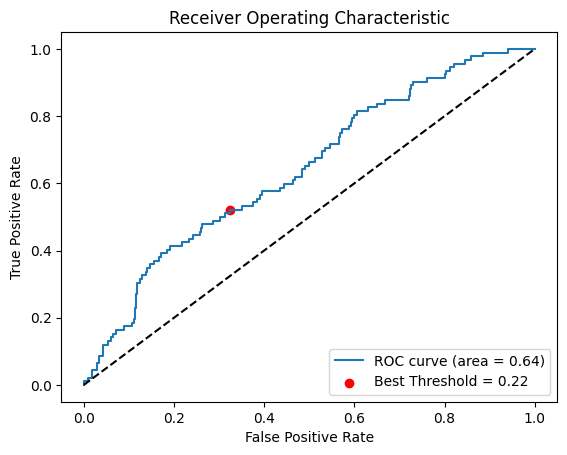

Area Under Curve: 0.6420229967660798
Best Threshold (closest to (0,1)): 0.22451372


In [28]:
threshold_custom, auc_custom = getROC(resnet_custom, val_dataset)

In [29]:
evalResNet(resnet_custom, test_dataset, threshold_custom,auc_custom)

Total examples: 648

 --------------------- 

Accuracy for Class 0: 56.48%  (318 in 563)
Accuracy for Class 1: 77.65%  (66 in 85)
Test Accuracy: 59.26%
Weighted Accuracy: 74.83%

 --------------------- 

Area Under Curve: 0.6420229967660798

 --------------------- 

F1 Score (Macro): 0.520
F1 Score (Weighted): 0.658
F1 Score Class 0: 0.707
F1 Score Class 1: 0.333

 --------------------- 


Confusion Matrix: 
 [[318 245]
 [ 19  66]]


## Custom test split and augmentations

The initial idea consisted of creating new slice files by applying the transformations mentioned in `1 - dataPreprocessing`, with guaranteed effect. However, after consultation with advisor, the new process consists of applying successive transofrmations with some degree of probability of non-application, as well as introudction of a new augmantation technique (Gaussian Blur). 

These methods should improve overall generalization.

In [30]:
# Paths
img_dir = r'..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = train_df
annotations_file_test = test_df
annotations_file_val = val_df

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Augmentations
augment = A.Compose([
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)

SliceID at index 977: 38__CT-0002-0002.npy
(224, 224, 3)


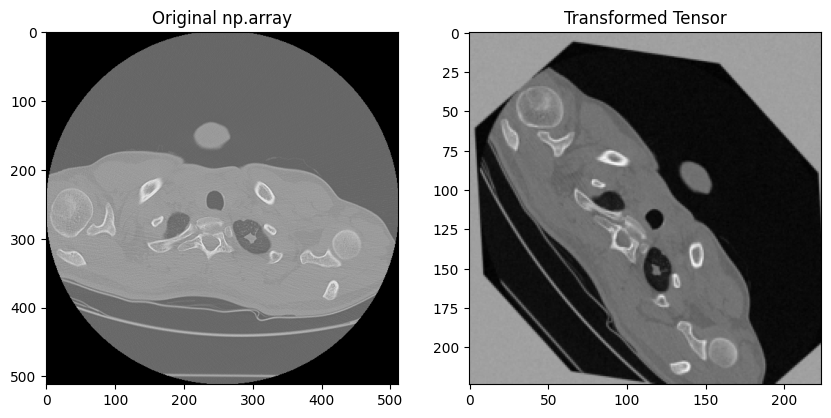

In [31]:
tensorVSnp(train_dataset, False)

In [32]:
models_path = "..\\..\\trainedResNets\\"

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    resnet_custom_aug, custom_aug_loss, custom_aug_val_loss = trainResNet(train_dataset,val_dataset,num_epochs=40)

    with open(r'pickleJar\custom_aug_loss.pkl', 'wb') as f:
        pickle.dump(custom_aug_loss, f)

    with open(r'pickleJar\custom_aug_val_loss.pkl', 'wb') as f:
        pickle.dump(custom_aug_val_loss, f)

elif ans == "read": 
    resnet_custom_aug = torch.load((f"{models_path}"+"resnet_custom_aug.pkl"))

    with open(r'pickleJar\custom_aug_loss.pkl', 'rb') as f:
        custom_aug_loss = pickle.load(f)

    with open(r'pickleJar\custom_aug_val_loss.pkl', 'rb') as f:
        custom_aug_val_loss = pickle.load(f)
    

else: print("Invalid answer, try again.")

C:\Users\hasht\AppData\Local\Temp\ipykernel_4888\3662648823.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_custom_aug = torch.load((f"{models_path}"+"resnet_cus

In [166]:
ans = str(input("Do you wish to save?"))

if ans == "yes": torch.save(resnet_custom_aug, (f"{models_path}"+"resnet_custom_aug.pkl"))
else: print("DID NOT SAVE")

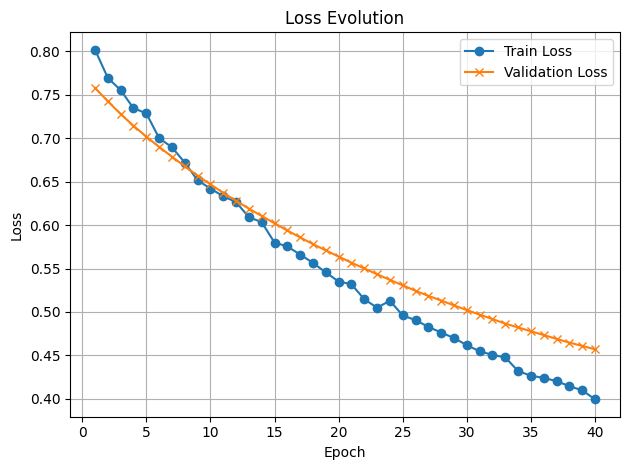

In [35]:
plotLoss(custom_aug_loss, custom_aug_val_loss)

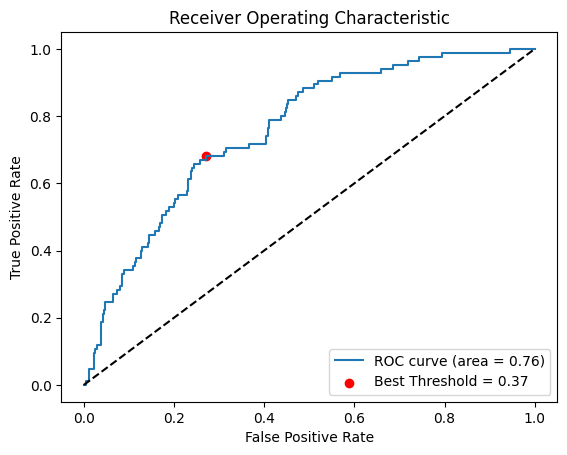

Area Under Curve: 0.7593354926339985
Best Threshold (closest to (0,1)): 0.36896533


In [33]:
threshold_custom_aug, auc_augment = getROC(resnet_custom_aug, val_dataset)

In [34]:
evalResNet(resnet_custom_aug, test_dataset, threshold_custom_aug, auc_augment)

Total examples: 648

 --------------------- 

Accuracy for Class 0: 72.82%  (410 in 563)
Accuracy for Class 1: 68.24%  (58 in 85)
Test Accuracy: 72.22%
Weighted Accuracy: 68.85%

 --------------------- 

Area Under Curve: 0.7593354926339985

 --------------------- 

F1 Score (Macro): 0.606
F1 Score (Weighted): 0.764
F1 Score Class 0: 0.820
F1 Score Class 1: 0.392

 --------------------- 


Confusion Matrix: 
 [[410 153]
 [ 27  58]]


In [169]:
ans = str(input("Do you wish to save models? (WARNING: OVERWRITES!!!)"))

if ans.lower() == 'yes':
    torch.save(resnet_hrct, (f"{models_path}"+"resnet_hrct.pkl"))
    torch.save(resnet_custom, (f"{models_path}"+"resnet_custom.pkl"))
    torch.save(resnet_custom_aug, (f"{models_path}"+"resnet_custom_aug.pkl"))